# Omics Pipe GUI -- RNAseq_Count_Based Pipeline

Author: K. Fisch
Email: Kfisch@ucsd.edu
Date: March 2016

#### Note: Before editing this notebook, please make a copy (File --> Make a copy).

## Table of Contents

<a id = "toc"></a>
1. <a href = "#intro">Introduction</a>
    * <a href = "#config">Configuration</a>
    * <a href = "#params">Parameters</a>
    * <a href = "#input">User Input Required </a>
2. <a href = "#pipeline">Omics Pipe RNAseq Count-based Pipeline</a>
3. <a href = "#results">Omics Pipe Results</a>
    * <a href = "#qc">Raw Data Quality Control (FastQC)</a>
    * <a href = "#alignment">Alignment (STAR)</a>
    * <a href = "#counts">Quantification (HTSeq)</a>
    * <a href = "#deseq">Differential Expression Analysis (DEseq2)</a>
4. <a href = "#enrichment">Functional Enrichment Analysis</a>
5. <a href = "#network">Network Analysis</a>

<a id = "intro"></a>
## Introduction

Omics pipe is an open-source, modular computational platform that automates ‘best practice’ multi-omics data analysis pipelines.  
This Jupyter notebook wraps the functionality of Omics Pipe into an easy-to-use interactive Jupyter notebook and parses
the output for genomic interpretation. Read more about Omics Pipe at https://pythonhosted.org/omics_pipe/.

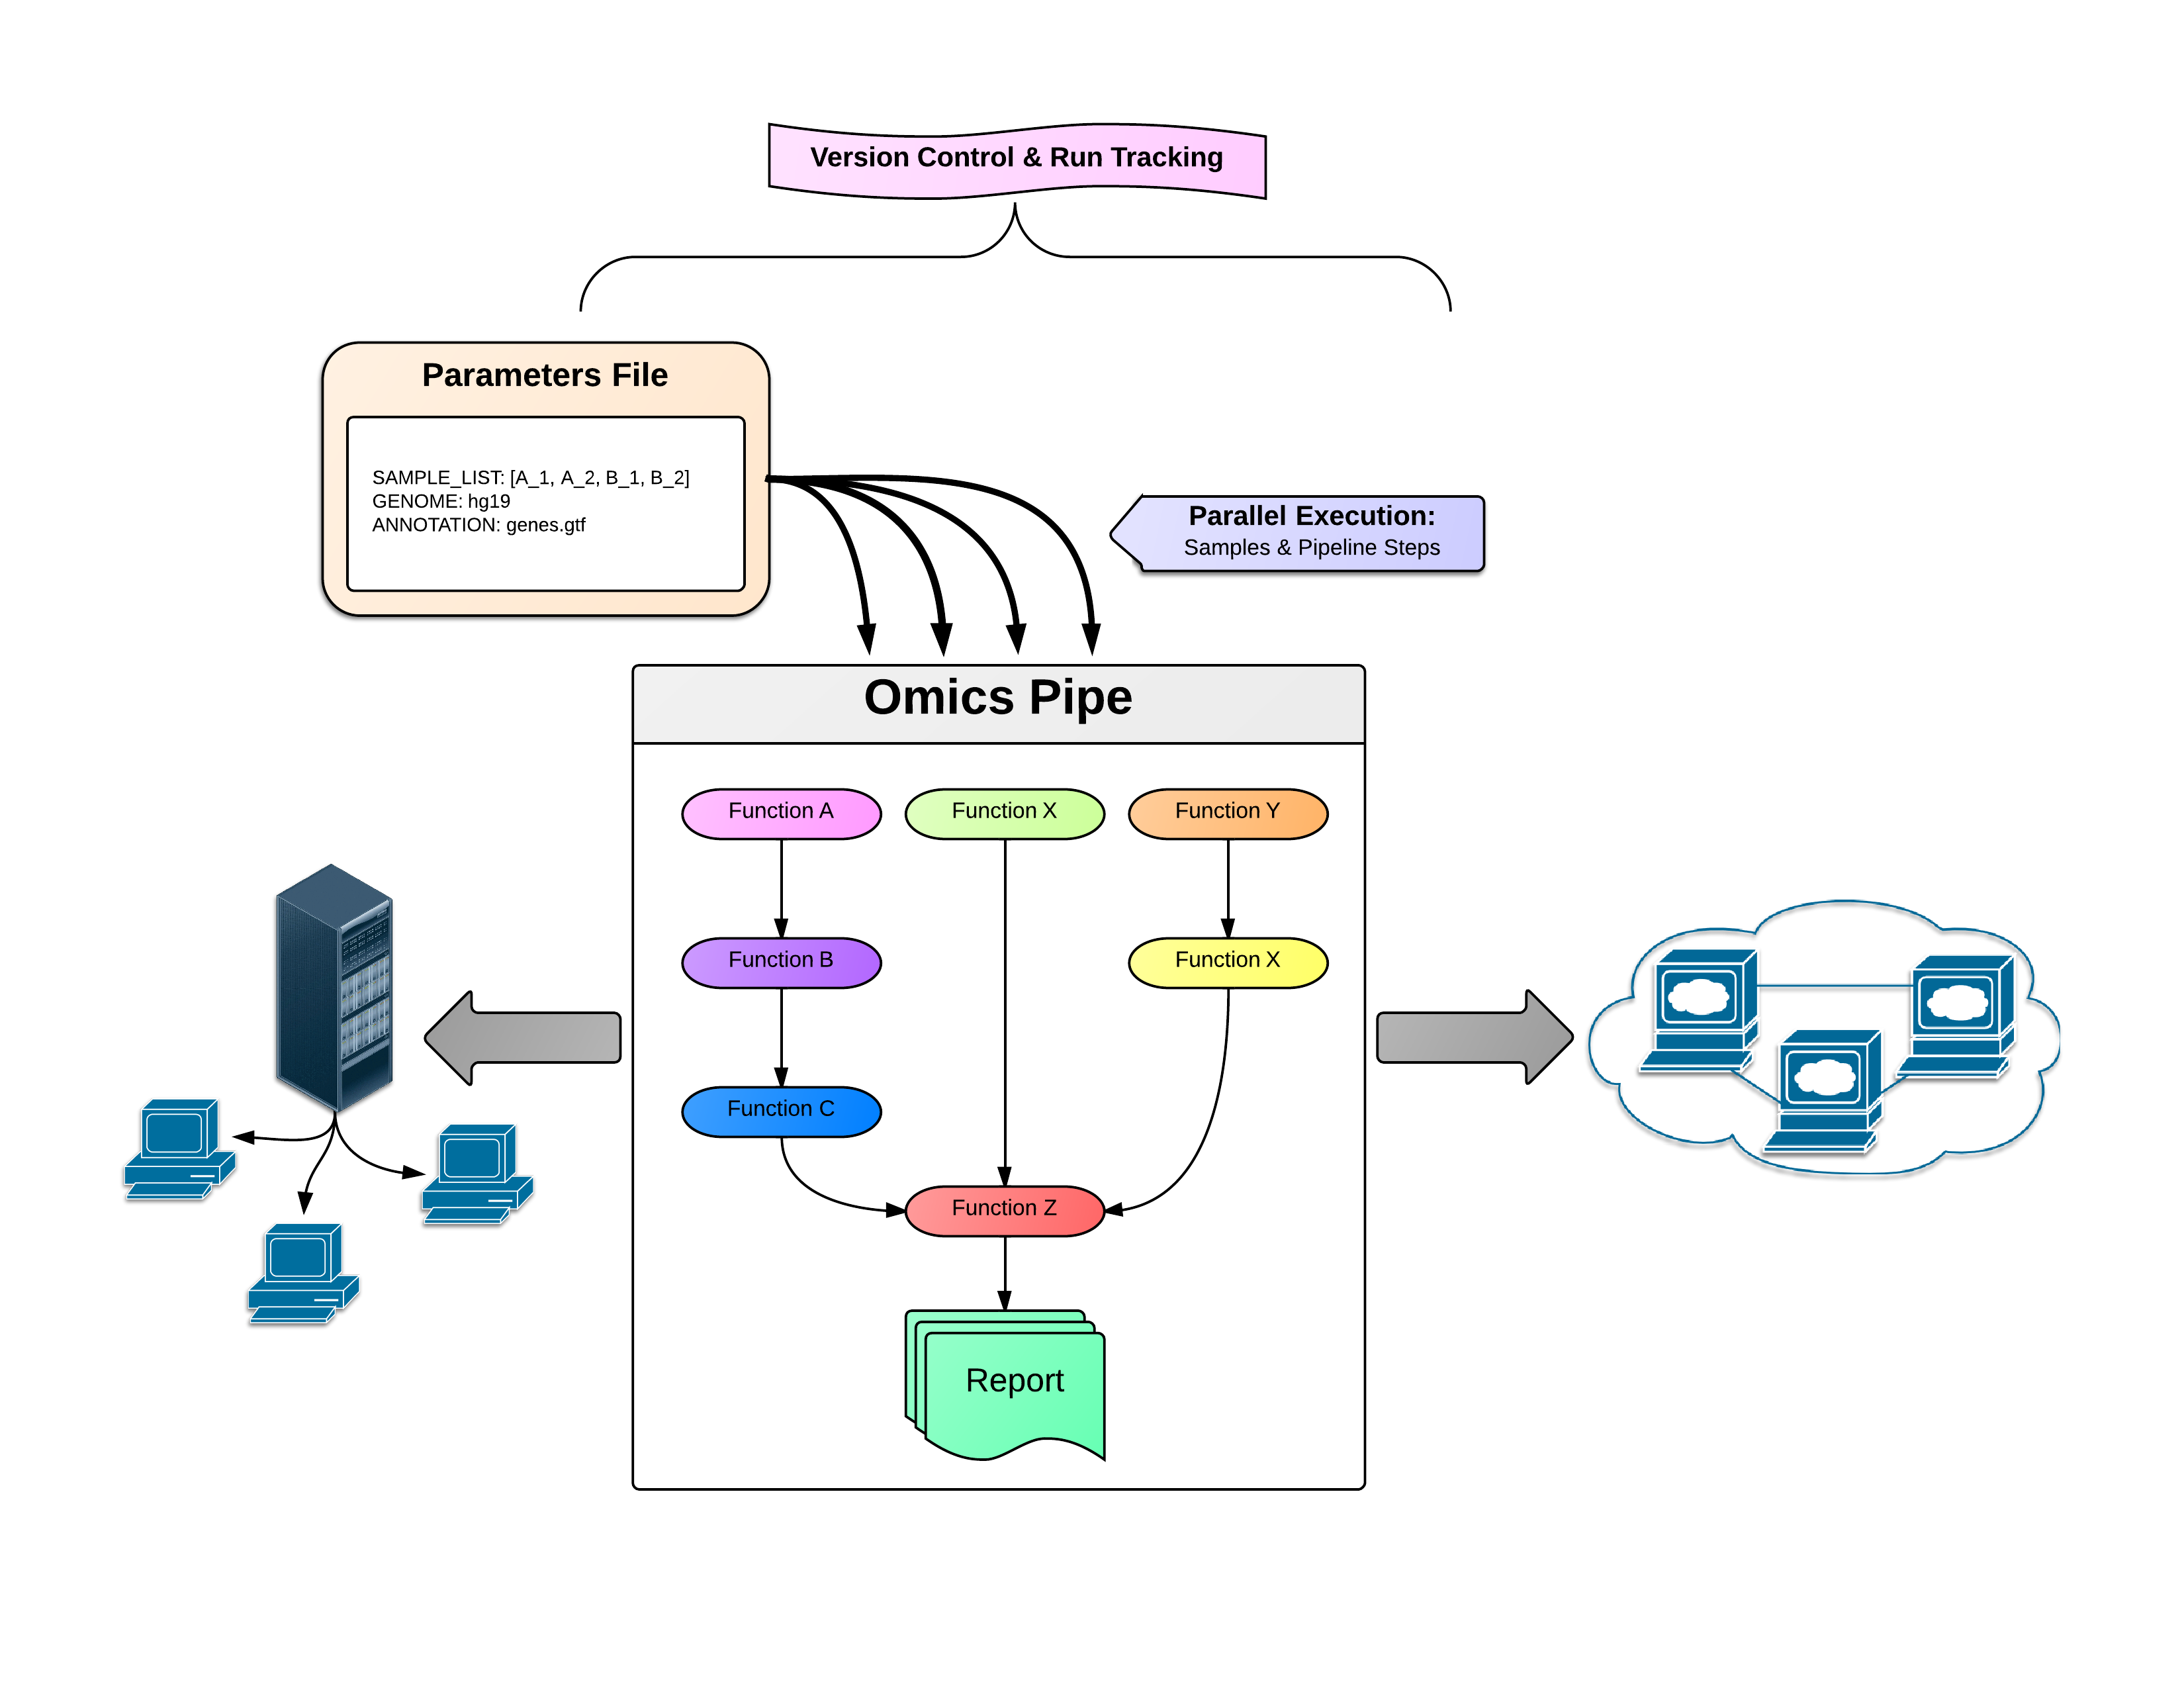

In [2]:
#Omics Pipe Overview
from IPython.display import Image
Image(filename='/data/notebooks/core_analysis_pipelines/RNAseq/Omics_Pipe_RNAseq_count_based_pipeline/images/op_diagram.png', width=500, height=100)

<a id = "config"></a>
### Set up your Jupyter notebook to enable nbextensions and import Python modules needed

In [3]:
#Activate Jupyter Notebook Extensions
import notebook
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/codefolding/main')
E.enable_nbextension('usability/comment-uncomment/main')
E.enable_nbextension('usability/datestamper/main')
E.enable_nbextension('usability/dragdrop/main')
E.enable_nbextension('usability/hide_input/main')
#E.enable_nbextension('usability/read-only/main')
E.enable_nbextension('usability/runtools/main')
E.enable_nbextension('usability/search-replace/main')
E.enable_nbextension('usability/toc/main')

#disable extension
#D = notebook.nbextensions.DisableNBExtensionApp()
#D.disable_nbextension('usability/codefolding/main')

In [5]:
#Import Omics pipe and module dependencies
import yaml
from omics_pipe.parameters.default_parameters import default_parameters 
from ruffus import *
import sys 
import os
import time
import datetime 
import drmaa
import csv
from omics_pipe.utils import *
from IPython.display import IFrame
import pandas
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, precision=4)
from IPython.display import HTML
import mygene

In [6]:
#Change top directory to locate result files
os.chdir("/data/results/boyle")

<a id = "params"></a>
### Customize input parameters for Omics Pipe

Required: Sample names, condition for each sample

Optional: genome build, gene annotation, output paths, tool parameters, etc. 

See full Omics Pipe documentation for a description of the configurable parameters. 

In [7]:
#Omics Pipe documentation: Parameters
IFrame("https://pythonhosted.org/omics_pipe/parameter_file.html", width=700, height=250)

<a id = "input"></a>
## ***User Input Required Here ***

In [8]:
###Customize parameters: Specify sample names and conditions
sample_names = ["RA2284-2D-C","RA2284-2D-10","RA2284-2D-50","RA2284-3D-C","RA2284-3D-10","RA2284-3D-50","RA2308-2D-C","RA2308-2D-TNFa","RA2308-3D-C","RA2308-3D-TNFa","RA2320-2D-C","RA2320-2D-TNFa","RA2320-3D-C","RA2320-3D-TNFa","RA2456-2D-C","RA2456-2D-10","RA2456-2D-50","RA2456-3D-C","RA2456-3D-10","RA2456-3D-50"]
condition = ["Control","TNF10","TNF50","Control","TNF10","TNF50","Control","TNF10","Control","TNF10","Control","TNF10","Control","TNF10","Control","TNF10","TNF50","Control","TNF10","TNF50"]
lib_type = ["single_end"]*len(condition)
tissue = ["Knee","Knee","Knee","Knee","Knee","Knee","Knee","Knee","Knee","Knee","Hip","Hip","Hip","Hip","Hip","Hip","Hip","Hip","Hip","Hip"]
culture = ["2D","2D","2D","3D","3D","3D","2D","2D","3D","3D","2D","2D","3D","3D","2D","2D","2D","3D","3D","3D"]

In [9]:
#Update Metadata File
meta = {'Sample': pandas.Series(sample_names), 'condition': pandas.Series(condition) , 'libType': pandas.Series(lib_type),'tissue': pandas.Series(tissue),'culture': pandas.Series(culture)}
meta_df = pandas.DataFrame(data = meta)
deseq_meta_new = "/data/results/boyle/meta.csv"
meta_df.to_csv(deseq_meta_new,index=False)
print meta_df

            Sample condition culture     libType tissue
0      RA2284-2D-C   Control      2D  single_end   Knee
1     RA2284-2D-10     TNF10      2D  single_end   Knee
2     RA2284-2D-50     TNF50      2D  single_end   Knee
3      RA2284-3D-C   Control      3D  single_end   Knee
4     RA2284-3D-10     TNF10      3D  single_end   Knee
5     RA2284-3D-50     TNF50      3D  single_end   Knee
6      RA2308-2D-C   Control      2D  single_end   Knee
7   RA2308-2D-TNFa     TNF10      2D  single_end   Knee
8      RA2308-3D-C   Control      3D  single_end   Knee
9   RA2308-3D-TNFa     TNF10      3D  single_end   Knee
10     RA2320-2D-C   Control      2D  single_end    Hip
11  RA2320-2D-TNFa     TNF10      2D  single_end    Hip
12     RA2320-3D-C   Control      3D  single_end    Hip
13  RA2320-3D-TNFa     TNF10      3D  single_end    Hip
14     RA2456-2D-C   Control      2D  single_end    Hip
15    RA2456-2D-10     TNF10      2D  single_end    Hip
16    RA2456-2D-50     TNF50      2D  single_end

In [ ]:
###Update parameters, such as GENOME, GTF_FILE, paths, etc
parameters = "/root/src/omics-pipe/tests/test_params_RNAseq_counts_AWS.yaml"
stream = file(parameters, 'r')
params = yaml.load(stream)
params.update({"SAMPLE_LIST": sample_names})
params.update({"DESEQ_META": deseq_meta_new})
params.update({"R_VERSION": '3.2.3'})
params.update({"REF_GENES": '/data/database/gencode/gencode.v19.annotation.gtf'})
params.update({"RAW_DATA_DIR": '/data/results/boyle'})
params.update({"LOG_PATH": ':/data/results/boyle/logs'})
params.update({"STAR_RESULTS": '/data/results/boyle/star'})
params.update({"QC_PATH": '/data/results/boyle/QC'})
params.update({"FLAG_PATH": '/data/results/boyle/flags'})
params.update({"HTSEQ_RESULTS": '/data/results/boyle/counts'})
params.update({"REPORT_RESULTS": '/data/results/boyle/report'})
params.update({"DESEQ_RESULTS": '/data/results/boyle/deseq'})
params.update({"TEMP_DIR": '/data/results/tmp'})
params.update({"PIPE_MULTIPROCESS": 100})
params.update({"PARAMS_FILE": '/data/results/boyle/Boyle_Omics_Pipe_Params_20160417.yaml'})
default_parameters.update(params)

#write yaml file
stream = file('Boyle_Omics_Pipe_Params_20160417.yaml', 'w')
yaml.dump(params,stream)
p = Bunch(default_parameters)
#View Parameters
print "Run Parameters: \n" + str(params)

<a id = "pipeline"></a>
## Omics Pipe RNAseq Count-based Pipeline

The following commands execute the Omics Pipe RNAseq Count-based Pipeline which is based on the Nature Methods paper Anders et al. 2013.

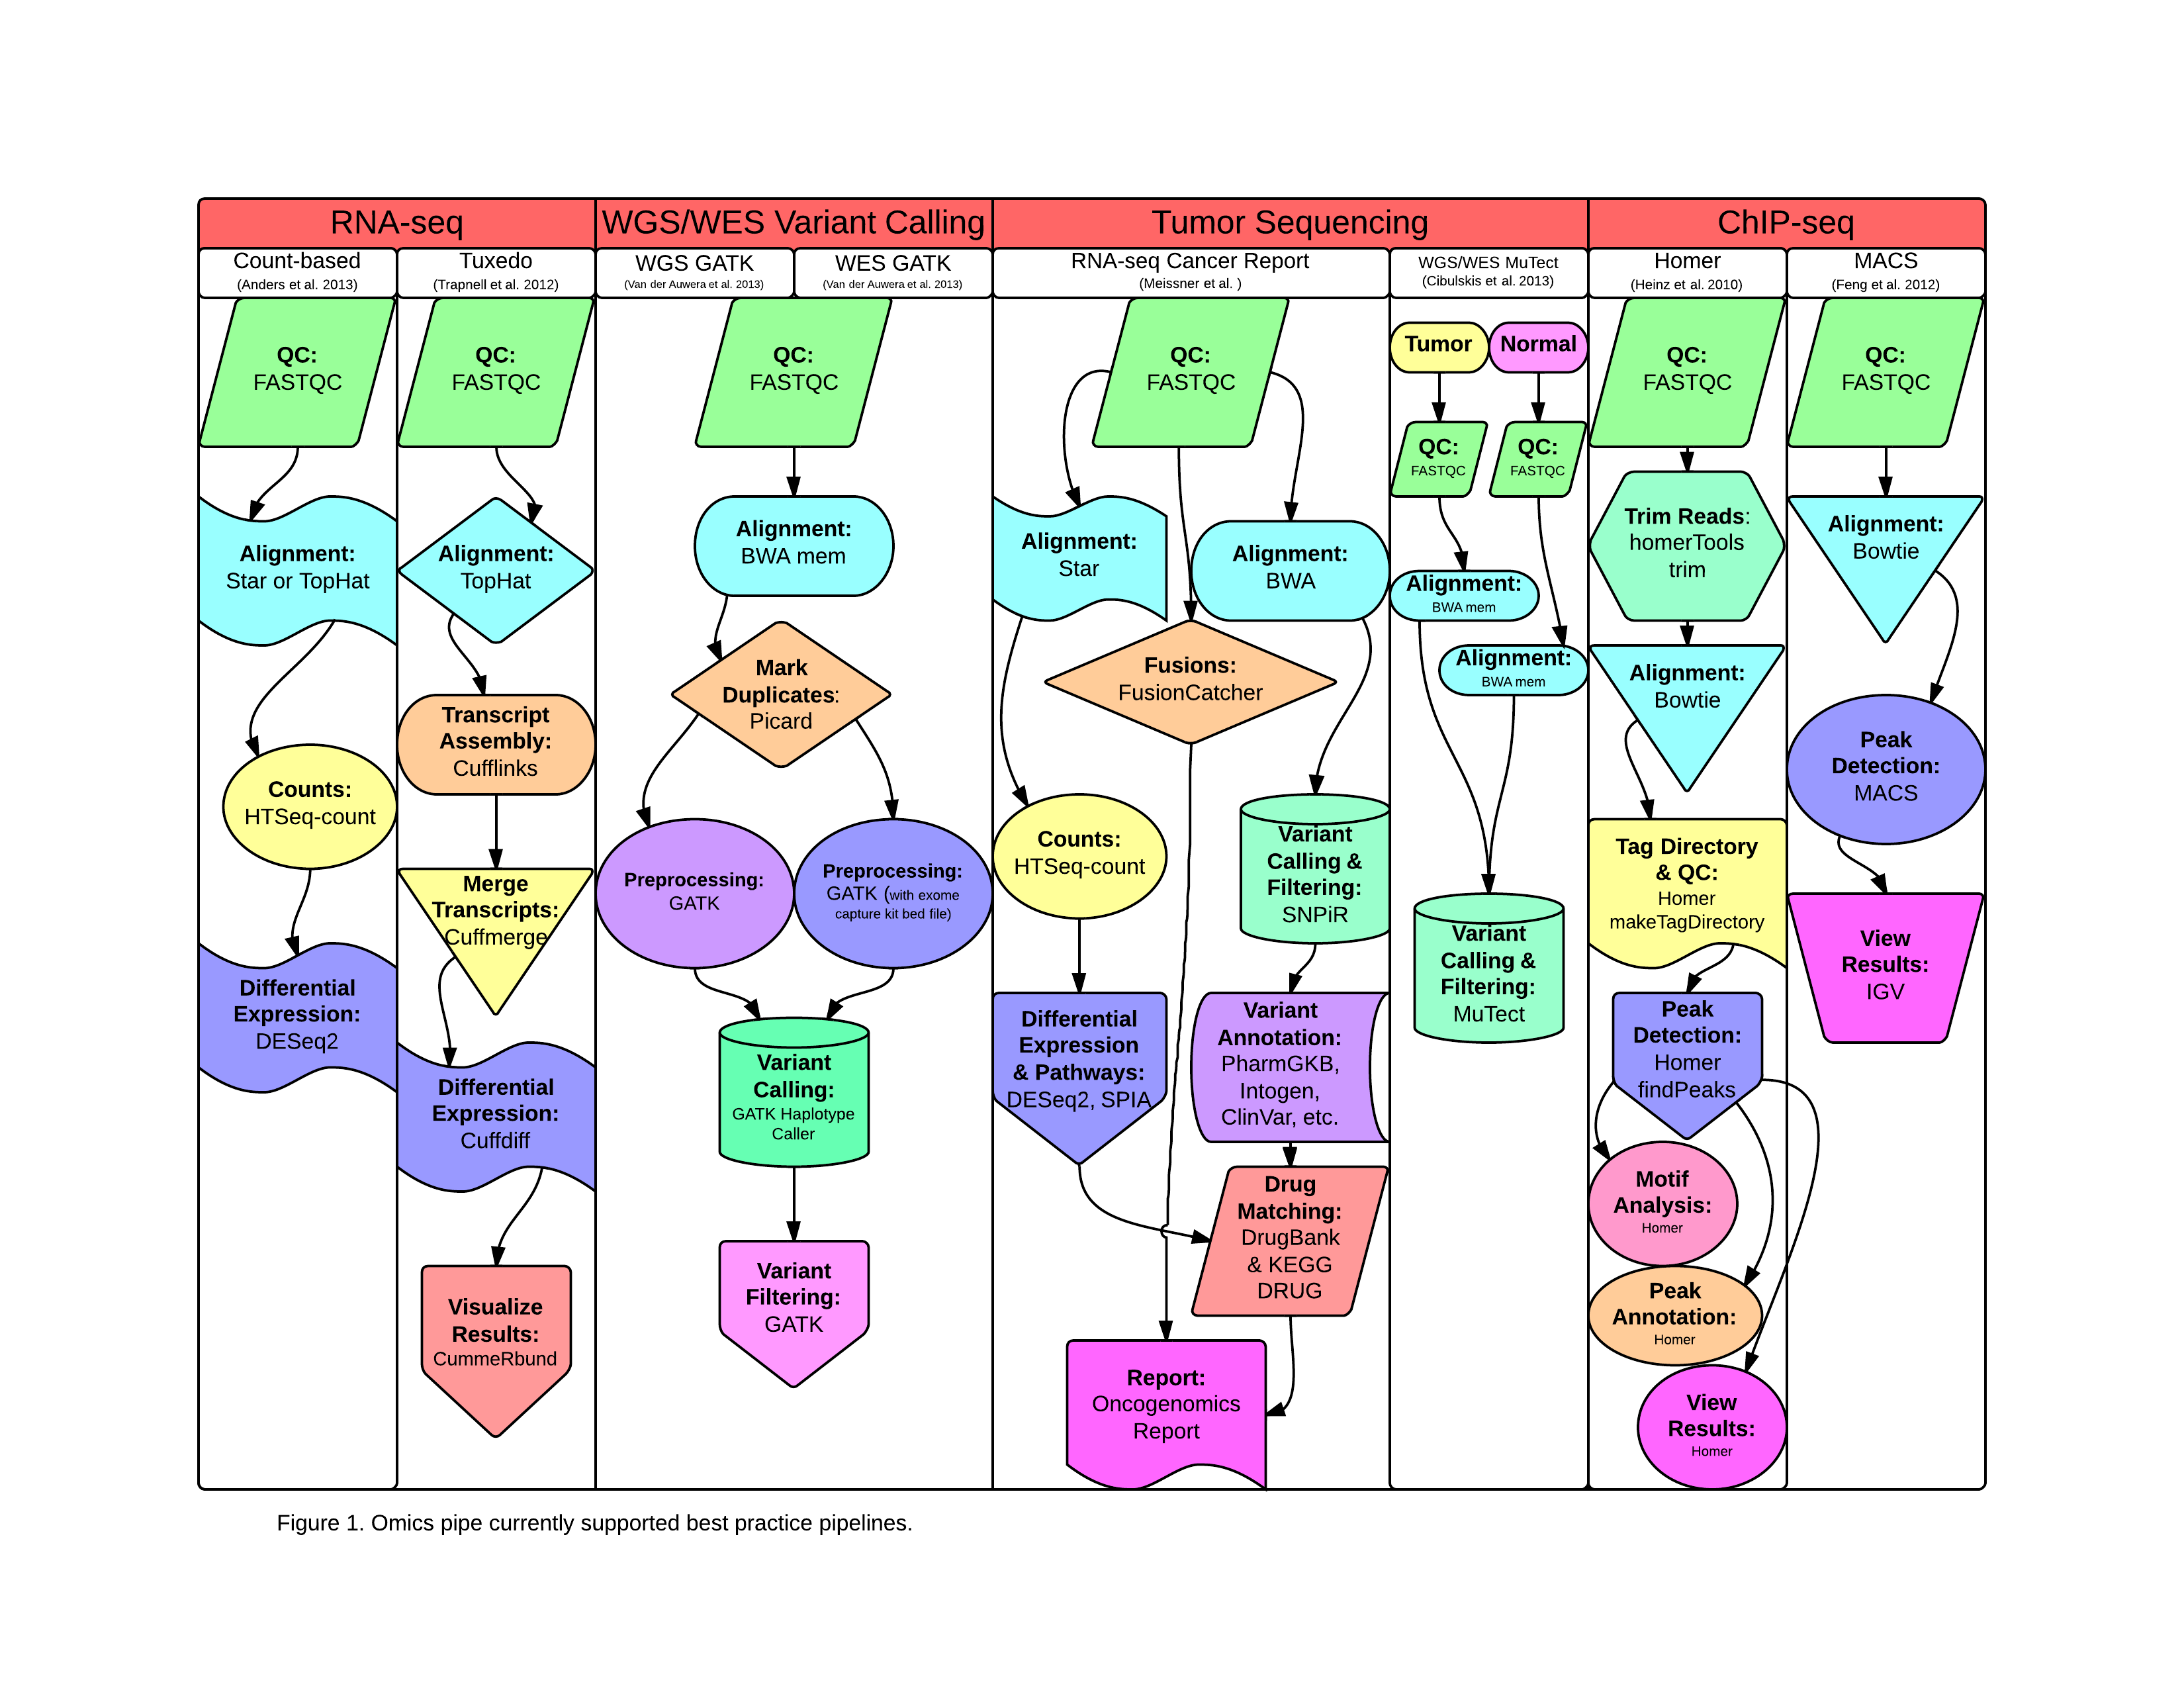

In [13]:
### Omics Pipe Pipelines
from IPython.display import Image
Image(filename='/data/notebooks/core_analysis_pipelines/RNAseq/Omics_Pipe_RNAseq_count_based_pipeline/images/op_pipelines.png', width=700, height=150)

In [24]:
#Import Omics Pipe RNAseq_count_based pipeline functions from pipeline script
#from omics_pipe.RNAseq_count_based import *
#import omics_pipe.RNAseq_count_based
from omics_pipe.utils import check_file_exists
from ruffus import *

### Only execute the following cell if you are running this pipeline on your own instance/cluster. It will not function on the test server.
#### Uncomment the pipeline_run command below

In [ ]:
###Runs Omics Pipe RNAseq_count_based pipeline with updated parameters. Requires c3.8xlarge instance to run. 

### Issues
##1. fastqc fails with java memory issue when launched through notebook. works from command line op

from omics_pipe.modules.fastqc import fastqc
from omics_pipe.modules.star import star
from omics_pipe.modules.htseq import htseq
from omics_pipe.modules.RNAseq_report_counts import RNAseq_report_counts

from omics_pipe.parameters.default_parameters import default_parameters 


os.chdir(p.WORKING_DIR)
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d %H:%M")    

with open(p.DESEQ_META,"rb") as infile:
    next(infile, None)
    reader=csv.reader(infile) 
    samples = [x[0] for x in reader]

for step in p.STEPS:
    vars()['inputList_' + step] = []
    for sample in samples:
        vars()['inputList_' + step].append([sample, "%s/%s_%s_completed.flag" % (p.FLAG_PATH, step, sample)])
    
@parallel(inputList_fastqc)
@check_if_uptodate(check_file_exists)
def run_fastqc(sample, fastqc_flag):
    fastqc(sample, fastqc_flag)
    return

@parallel(inputList_star)
@check_if_uptodate(check_file_exists)
def run_star(sample, star_flag):
    star(sample, star_flag)
    return

@follows(run_star)
@parallel(inputList_htseq)
@check_if_uptodate(check_file_exists)
def run_htseq(sample, htseq_flag):
    htseq(sample, htseq_flag)
    return

@follows(run_fastqc, run_htseq)
@parallel([["report", "%s/RNAseq_report_report_completed.flag" % (p.FLAG_PATH)]])
@check_if_uptodate(check_file_exists)
def run_RNAseq_report_counts(sample, RNAseq_report_counts_flag):
    RNAseq_report_counts(sample, RNAseq_report_counts_flag)
    return

@follows(run_RNAseq_report_counts)
@parallel([["combined", "%s/last_function_combined_completed.flag" % (p.FLAG_PATH)]])
@check_if_uptodate(check_file_exists)
def last_function(sample, last_function_flag):
    print "PIPELINE HAS FINISHED SUCCESSFULLY!!! YAY!"
    pipeline_graph_output = p.FLAG_PATH + "/pipeline_" + sample + "_" + str(date) + ".pdf"
    pipeline_printout_graph (pipeline_graph_output,'pdf', step, no_key_legend=False)
    stage = "last_function"
    flag_file = "%s/%s_completed.flag" % (p.FLAG_PATH, stage)
    open(flag_file, 'w').close()
    return   

#Uncomment this if you are going to run
#pipeline_run(p.STEP, multiprocess = p.PIPE_MULTIPROCESS, verbose = p.PIPE_VERBOSE, gnu_make_maximal_rebuild_mode = p.PIPE_REBUILD)


<a id = "results"></a>
## Omics Pipe Results

Omics Pipe produces output files for each of the steps in the pipeline, as well as log files and run information (for reproducibility). 
Summarized output for each of the steps is displayed below for biological interpretation. 

In [11]:
#Change top directory to locate result files
os.chdir("/data/core_analysis_pipelines/RNAseq/Omics_Pipe_RNAseq_count_based_pipeline")

In [12]:
#Display Omics Pipe Pipeline Run Status
#pipeline = './flags/pipeline_combined_%s.pdf' % date
pipeline = './flags/pipeline_combined_2016-03-10 20:10.pdf'
IFrame(pipeline, width=700, height=500)

<a id = "qc"></a>
### Quality Control of Raw Data -- FastQC

Quality control of the raw data (fastq files) was assessed using the tool FastQC (http://www.bioinformatics.babraham.ac.uk/projects/fastqc/). 
The results for all samples are summarized below, and samples are given a PASS/FAIL rating. 

In [13]:
###Summarize FastQC raw data QC results per sample
results_dir = './QC/'
# Below is the complete list of labels in the summary file
summary_labels = ["Basic Statistics", "Per base sequence quality", "Per tile sequence quality", 
                  "Per sequence quality scores", "Per base sequence content", "Per sequence GC content", 
                  "Per base N content", "Sequence Length Distribution", "Sequence Duplication Levels", 
                  "Overrepresented sequences", "Adapter Content", "Kmer Content"]

# Below is the list I anticipate caring about; I leave the full list above in case it turns out later
# I anticipated wrong and need to update this one.
labels_of_interest = ["Basic Statistics", "Per base sequence quality"]

# Look for each file named summary.txt in each subdirectory named *_fastqc in the results directory
summary_wildpath = os.path.join(results_dir, '*/*_fastqc', "summary.txt")
summary_filepaths = [x for x in glob.glob(summary_wildpath)]
#print os.getcwd()
# Examine each of these files to find lines starting with "FAIL" or "WARN"
for curr_summary_path in summary_filepaths:
    has_error = False
    #print(divider)    
    with open(curr_summary_path, 'r') as f:
        for line in f:
            if line.startswith("FAIL") or line.startswith("WARN"):
                fields = line.split("\t")
                if not has_error:
                    print(fields[2].strip() + ": PASS") # the file name
                    has_error = True                    
                if fields[1] in labels_of_interest:
                    print(fields[0] + "\t" + fields[1])

27_2_1_LPS_S30.fastq: PASS
M01_LPS_S2.fastq: PASS
M13_LPS_S10.fastq: PASS
GM_55A_CTRL_S21.fastq: PASS
27_2_2_LPS_S32.fastq: PASS
M17_LPS_S14.fastq: PASS
M07_LPS_S4.fastq: PASS
Hoffman_32_S37.fastq: PASS
M10_CTRL_S5.fastq: PASS
GM_50A_CTRL_S17.fastq: PASS
M18_LPS_S24.fastq: PASS
M17_CTRL_S13.fastq: PASS
M01_CTRL_S1.fastq: PASS
27_2_1_CTRL_S29.fastq: PASS
Hoffman_LPS_S39.fastq: PASS
M10_LPS_S6.fastq: PASS
M14_CTRL_S11.fastq: PASS
GM_54B_CTRL_S19.fastq: PASS
27_2_2_CTRL_S31.fastq: PASS
M18_CTRL_S23.fastq: PASS
Affy_Hela_Control_S35.fastq: PASS
GM_55A_LPS_S22.fastq: PASS
M14_LPS_S12.fastq: PASS
GM_46D_CTRL_S15.fastq: PASS
M11_LPS_S8.fastq: PASS
M11_CTRL_S7.fastq: PASS
GM_54B_LPS_S20.fastq: PASS
BG_Harris_CTRL_S27.fastq: PASS
GM_46D_LPS_S16.fastq: PASS
Hoffman_37_S38.fastq: PASS
BG_Harris_LPS_S28.fastq: PASS
M07_CTRL_S3.fastq: PASS
M13_CTRL_S9.fastq: PASS
GM_50A_LPS_S18.fastq: PASS


In [14]:
#Display QC results for individual samples
#sample = 
name = './QC/%s/%s_fastqc/fastqc_report.html' % (sample,sample)
IFrame(name, width=1000, height=600)

<a id = "alignment"></a>
### Alignment Summary Statistics -- STAR

The samples were aligned to the genome with the STAR aligner (https://github.com/alexdobin/STAR). 
The alignment statistics for all samples are summarized and displayed below. Samples that do not pass the alignment quality filter 
(Good quality = # aligned reads > 10 million and % aligned > 60%) are excluded from downstream analyses. 

In [15]:
##Summarize Alignment QC Statistics
import sys
from io import StringIO
star_dir = './star/'
# Look for each file named summary.txt in each subdirectory named *_fastqc in the results directory
#summary_wildpath = os.path.join(star_dir, '*/', "Log.final.out")
summary_wildpath = os.path.join(star_dir, "*Log.final.out")
summary_filepaths = [x for x in glob.glob(summary_wildpath)]
#print summary_filepaths

alignment_stats = pandas.DataFrame()
for curr_summary_path in summary_filepaths:    
    #with open(curr_summary_path, 'r') as f:
    filename = curr_summary_path.replace("./star/","")
    filename2 = filename.replace("_Log.final.out","")
    df = pandas.read_csv(curr_summary_path, sep="\t", header=None)
    raw_reads = df.iloc[[4]]
    y = raw_reads[1].to_frame()
    aligned_reads = df.iloc[[7]]
    z = aligned_reads[1].to_frame()
    percent_aligned = df.iloc[[8]]
    #print percent_aligned
    a = percent_aligned[1]
    b = a.to_string() 
    c = b.replace("%","")
    c1 = c.replace("8    ","")
    e = float(c1)
    d = {"Sample": pandas.Series(filename2), "Raw_Reads": pandas.Series(float(y[1])),
         "Aligned_Reads": pandas.Series(float(z[1])),
         "Percent_Uniquely_Aligned": pandas.Series(e)}
    p = pandas.DataFrame(data=d)
    alignment_stats = alignment_stats.append(p)
#print alignment_stats

#View interactive table 
qgrid.show_grid(alignment_stats, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})

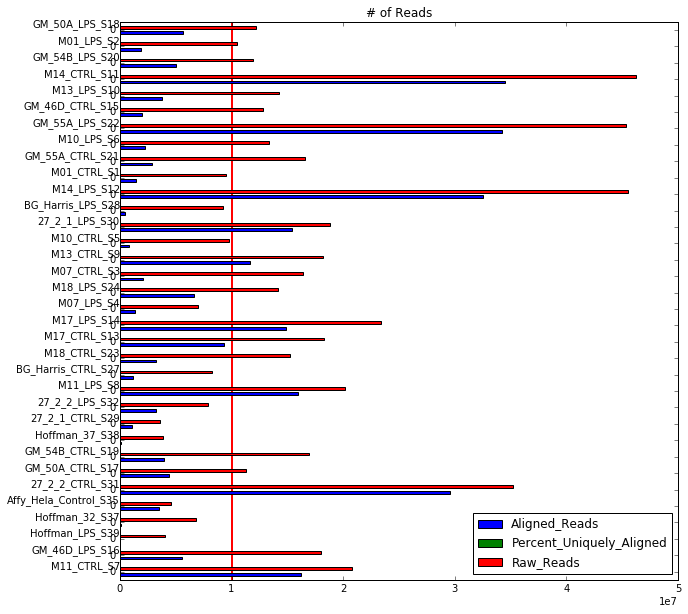

In [16]:
#Barplot of number of aligned reads per sample
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
alignment_stats.plot(ax=ax, kind='barh', title='# of Reads')
ax.axis(x='off')
ax.axvline(x=10000000, linewidth=2, color='Red', zorder=0)
#plt.xlabel('# Aligned Reads',fontsize=16)
for i, x in enumerate(alignment_stats.Sample):
    ax.text(0, i + 0, x, ha='right', va= "bottom", fontsize='medium')
plt.savefig('./alignment_stats_%s' %date ,dpi=300)  # save figure

In [17]:
###Flag samples with poor alignment or low numbers of reads
df = alignment_stats
failed_samples = df.loc[(df.Aligned_Reads < 10000000) | (df.Percent_Uniquely_Aligned < 60), ['Sample','Raw_Reads', 'Aligned_Reads', 'Percent_Uniquely_Aligned']]

#View interactive table 
qgrid.show_grid(failed_samples, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})

In [18]:
#View Alignment Statistics for failed samples
for failed in failed_samples["Sample"]:
    #fname = "/data/results/star/%s/Log.final.out" % failed
    fname = "./star/%s_Log.final.out" % failed
    with open(fname, 'r') as fin:
        print failed + fin.read()

GM_46D_LPS_S16                                 Started job on |	Mar 11 01:39:12
                             Started mapping on |	Mar 11 01:50:19
                                    Finished on |	Mar 11 01:55:23
       Mapping speed, Million of reads per hour |	213.44

                          Number of input reads |	18023481
                      Average input read length |	50
                                    UNIQUE READS:
                   Uniquely mapped reads number |	5521748
                        Uniquely mapped reads % |	30.64%
                          Average mapped length |	49.61
                       Number of splices: Total |	409891
            Number of splices: Annotated (sjdb) |	0
                       Number of splices: GT/AG |	406595
                       Number of splices: GC/AG |	3186
                       Number of splices: AT/AC |	110
               Number of splices: Non-canonical |	0
                      Mismatch rate per base, % |	0.20%
              

In [19]:
###Samples that passed QC for alignment 
passed_samples = df.loc[(df.Aligned_Reads > 10000000) | (df.Percent_Uniquely_Aligned > 60), ['Sample','Raw_Reads', 'Aligned_Reads', 'Percent_Uniquely_Aligned']]

print "Number of samples that passed alignment QC = " + str(len(passed_samples))
#View interactive table 
qgrid.show_grid(passed_samples, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})

Number of samples that passed alignment QC = 10


In [20]:
#View Alignment Statistics for passed samples
for passed in passed_samples["Sample"]:
    #fname = "/data/results/star/%s/Log.final.out" % passed
    fname = "./star/%s_Log.final.out" % passed
    with open(fname, 'r') as fin:
        print passed + fin.read()

M11_CTRL_S7                                 Started job on |	Mar 10 20:28:10
                             Started mapping on |	Mar 10 20:41:37
                                    Finished on |	Mar 10 20:49:13
       Mapping speed, Million of reads per hour |	163.94

                          Number of input reads |	20766255
                      Average input read length |	50
                                    UNIQUE READS:
                   Uniquely mapped reads number |	16243030
                        Uniquely mapped reads % |	78.22%
                          Average mapped length |	49.63
                       Number of splices: Total |	1110202
            Number of splices: Annotated (sjdb) |	0
                       Number of splices: GT/AG |	1099109
                       Number of splices: GC/AG |	10820
                       Number of splices: AT/AC |	273
               Number of splices: Non-canonical |	0
                      Mismatch rate per base, % |	0.24%
             

In [21]:
#Create new metadata file with samples that passed QC for differential expression analyses
passed_list = passed_samples["Sample"]
meta_df_passed = meta_df.loc[meta_df.Sample.isin(passed_list)]                        
deseq_meta_new2 = "/data/core_analysis_pipelines/RNAseq/Omics_Pipe_RNAseq_count_based_pipeline/results/new_meta_QCpassed.csv"
meta_df_passed.to_csv(deseq_meta_new2,index=False)
print meta_df_passed

                   Sample condition     libType
2             M11_CTRL_S7   control  single_end
3          27_2_1_LPS_S30       LPS  single_end
5              M11_LPS_S8       LPS  single_end
6         27_2_2_CTRL_S31   control  single_end
7          GM_55A_LPS_S22       LPS  single_end
8             M13_CTRL_S9   control  single_end
12  Affy_Hela_Control_S35   control  single_end
14           M14_CTRL_S11   control  single_end
17            M14_LPS_S12       LPS  single_end
23            M17_LPS_S14       LPS  single_end


# Differential Expression Analysis in R
## Switch to R Kernel at top of screen: Kernel --> Change Kernel --> R

In [1]:
#Load R packages; Execute this twice to clear the log
require(limma)
require(edgeR)
require(DESeq2)
require(RColorBrewer)
require(cluster)
library(gplots)
library(SPIA)
library(graphite)
library(PoiClaClu)
library(ggplot2)
library(pathview)
library(KEGG.db)
library(mygene)
library(topGO)
library(splitstackshape)
library(reshape)
date <- Sys.Date()

Loading required package: limma
Loading required package: edgeR
Loading required package: DESeq2
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Red


groupGOTerms: 	GOBPTerm, GOMFTerm, GOCCTerm environments built.



Attaching package: ‘topGO’

The following object is masked from ‘package:GenomicFeatures’:

    genes

The following object is masked from ‘package:IRanges’:

    members

Loading required package: data.table

Attaching package: ‘data.table’

The following object is masked from ‘package:SummarizedExperiment’:

    shift

The following object is masked from ‘package:GenomicRanges’:

    shift

The following object is masked from ‘package:IRanges’:

    shift


Attaching package: ‘reshape’

The following object is masked from ‘package:data.table’:

    melt

The following object is masked from ‘package:IRanges’:

    expand

The following object is masked from ‘package:S4Vectors’:

    rename



In [3]:
#Load custom R scripts
source("/data/core_analysis_pipelines/RNAseq/Omics_Pipe_RNAseq_count_based_pipeline/scripts/RNA_seq_DE.R")

Loading required package: DESeq
Loading required package: locfit
locfit 1.5-9.1 	 2013-03-22
Loading required package: lattice
    Welcome to 'DESeq'. For improved performance, usability and
    functionality, please consider migrating to 'DESeq2'.

Attaching package: ‘DESeq’

The following objects are masked from ‘package:DESeq2’:

    estimateSizeFactorsForMatrix, getVarianceStabilizedData,
    varianceStabilizingTransformation



In [4]:
#Compile individual count files
#======================================================================================================================================
#Specify working directory. Should be the name of your project, and there should be a subfolder within this
#directory named "counts" which contains the raw count files in .txt format for all samples (output from htseq in Omics Pipe)
setwd("/data/core_analysis_pipelines/RNAseq/Omics_Pipe_RNAseq_count_based_pipeline")

name<- "Prince_RNAseq_20160405"

#Reads in count files
dir <- paste(getwd(), "/counts", sep="")
countFiles <- paste(dir, "/", dir(dir), sep='')
countNames1 <- gsub('_counts.txt', '', countFiles)
countNames <- gsub(sprintf("%s/", dir), '', countNames1)
countsDf <- NULL
for (i in countFiles) {
  dat <- read.csv(i, header=F, sep="\t", na.strings="", as.is=T)
  countsDf <- cbind(countsDf, dat[,2])
}
x1 <- dim(countsDf)[1]-4
x2 <- dim(countsDf)[1]
countsDf <- countsDf[-c(x1:x2),] # remove the last 5 lines, they hold no genes
rownames(countsDf) <- read.csv(i, header=F, sep="\t", na.strings="", as.is=T)$V1[-c(x1:x2)]
colnames(countsDf) <- countNames
write.csv(countsDf, sprintf("%s_ALL_counts.csv", name)) #Creates file with all counts in one file

df <- countsDf
geneCount <- df
rc <- rowSums(geneCount)
geneCount <- geneCount[rc > 0,]
N <- colSums(geneCount)
names <- names(N)

In [5]:
# Preprocess data & read in metadata
#=====================================================================================================================================
#Read in design file. Example in s3://ucsd-ccb-data-analysis/Katie/RNAseq_scripts
#meta <- read.csv(sprintf("%s_design.csv",name), header=T, stringsAsFactor=FALSE)

#Read in design file with good quality samples only
meta <- read.csv("/data/core_analysis_pipelines/RNAseq/Omics_Pipe_RNAseq_count_based_pipeline/results/new_meta_QCpassed.csv", header=T, stringsAsFactors=FALSE)

meta <- meta[match(colnames(geneCount), meta$Sample), ] # sort meta data by colnames of count matrix
meta <- meta[complete.cases(meta),]
rownames(meta) <- meta$Sample
geneCount <- geneCount[,meta$Sample]
df<-df[,meta$Sample]
check <- cbind(meta$Sample, colnames(geneCount))
group <- meta$condition

# trs length (only needed for rpkm values)
trsLength <- NA
if(is.element("length", colnames(df)))
  trsLength <- df[rc > 0,"length"]

# normalization using deseq
norm <- getNormData(df, group, trsLength, addRaw=TRUE)
deseq <- log2(norm$DESeq+1)
sf_deseq <- getSizeFactor(df, group)$DESeq # save the size factors of the ref cohort
write.csv(deseq, sprintf("results/DEseq_normalized_counts_%s.csv",name))
# nonspecic Filtering
sds <- apply(deseq,1,sd)
use <- (sds > quantile(sds, 0.75))
deseqNsf <- deseq[use,]

In [6]:
#Differential expression
#=====================================================================================================================================
#Create DEseq dataset from matrix
dds <- DESeqDataSetFromMatrix(countData = geneCount, 
                              colData = meta,
                              design = ~ condition)
#Run differential expression analysis
dds <- DESeq(dds)
ddsClean <- replaceOutliersWithTrimmedMean(dds)
ddsClean <- DESeq(ddsClean)
res <- results(ddsClean)
#res <- results(ddsClean, contrast=c("condition", "KODN2", "WTDN3")) #Specify conditions for DE comparison here if more than two conditions

res <- res[order(res$padj),]

name2 <- "LPSvsControl_QC_test"
write.csv(res, sprintf("results/DE_transcripts_%s_%s_%s.csv", name, name2, date)) #Writes results of differential expression analysis to this file in your working dir


Warning message:
In DESeqDataSet(se, design = design, ignoreRank): some variables in design formula are characters, converting to factorsestimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [11]:
#View differentially expressed genes
head(res)

ERROR: Error in .classEnv(classDef): trying to get slot "package" from an object of a basic class ("NULL") with no slots


In [12]:
#Annotate Gencode file with gene type and other info from GTF file
#===================================================
gtf <- read.csv("/data/core_analysis_pipelines/RNAseq/Omics_Pipe_RNAseq_count_based_pipeline/scripts/gencode.v19.annotation.gtf", skip =5, header=FALSE, sep="\t")
names(gtf) <- c("chr", "def", "type", "start", "stop", "blank2", "strand", "blank3", 'info')
x <- cSplit(gtf, "info", sep=";")
x$info_01 <- sub('gene_id ', '', x$info_01)
x$info_02 <- sub('transcript_id ', '', x$info_02)
x$info_03 <- sub('gene_type ', '', x$info_03)
x$info_04 <- sub('gene_status ', '', x$info_04)
x$info_05 <- sub('gene_name ', '', x$info_05)
x$info_06 <- sub('transcript_type ', '', x$info_06)
x$info_07 <- sub('transcript_status ', '', x$info_07)
x$info_08<- sub('transcript_name ', '', x$info_08)
x$info_09 <- sub('level ', '', x$info_09)
ANNOT <- data.frame("Chr" = x$chr, "Start" = x$start, "Stop" = x$stop, "Strand" = x$strand, 
                    'gene_id' = x$info_01, 'transcript_id' = x$info_02, "gene_type" =x$info_03, "gene_name" = x$info_05)
y <- as.data.frame(res)

ANNOT_out <- merge(ANNOT, y, by.x="gene_id", by.y="row.names", all.x=FALSE,all.y=TRUE)
ANNOT_out_unique <- ANNOT_out[!duplicated(ANNOT_out),]
ANNOT_out_unique2 <- ANNOT_out[!duplicated(ANNOT_out_unique$gene_id),]
write.csv(ANNOT_out_unique2, sprintf("/results/Gene_exp_ID_conversion_%s_%s.csv",name, name2))

ANNOT_out_Coding <- subset(ANNOT_out_unique2, gene_type == "protein_coding")
write.csv(ANNOT_out_Coding, sprintf("/results/%s_%s_protein_coding.csv", name, name2))

ANNOT_out_lncRNA <- subset(ANNOT_out_unique, gene_type %in% c("3prime_overlapping_ncrna", "lincRNA", "antisense", "processed_transcript", "sense_overlapping", "sense_intronic"))
ANNOT_out_lncRNA_unique <- ANNOT_out_lncRNA[!duplicated(ANNOT_out_lncRNA$gene_id),]
write.csv(ANNOT_out_lncRNA_unique, sprintf("/results/%s_%s_lnc_RNA.csv", name, name2))


DE_lnc <- subset(ANNOT_out_lncRNA_unique, padj<0.05)
DE_coding <- subset(ANNOT_out_Coding, padj < 0.05)



In [19]:
write.csv(DE_lnc, sprintf("/results/DE_lncRNA_%s_%s.csv",name,name2))
write.csv(DE_coding, sprintf("/results/DE_coding_genes_%s_%s.csv", name,name2))

## Visualization

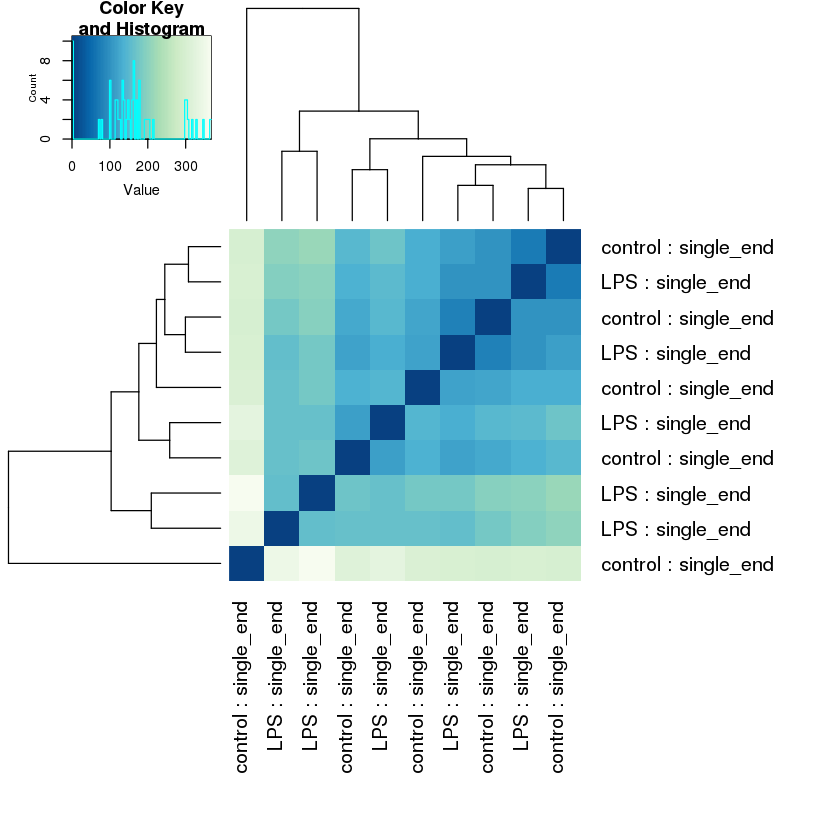

In [13]:
#Create distance matrix heatmap and clustering
#pdf(sprintf("%s_%s_plots_%s.pdf", name, name2,date))  #Uncomment this to save all plots to a pdf file
#png(sprintf("%s_%s_plots_%s.png", name, name2,date),res=1200, width=4,height=4, units='in')  #Uncomment this to save all plots to a pdf file

rld <- rlog(dds)
distsRL <- dist(t(assay(rld)))
mat <- as.matrix(distsRL)
rownames(mat) <- colnames(mat) <- with(colData(dds), paste(condition, libType, sep=" : "))
hmcol <- colorRampPalette(brewer.pal(9, "GnBu"))(100)
heatmap.2(mat, trace="none", col = rev(hmcol), margin=c(13, 13))

Warning message:
In rect(y1, x1, y2, x2, ...): supplied color is neither numeric nor character

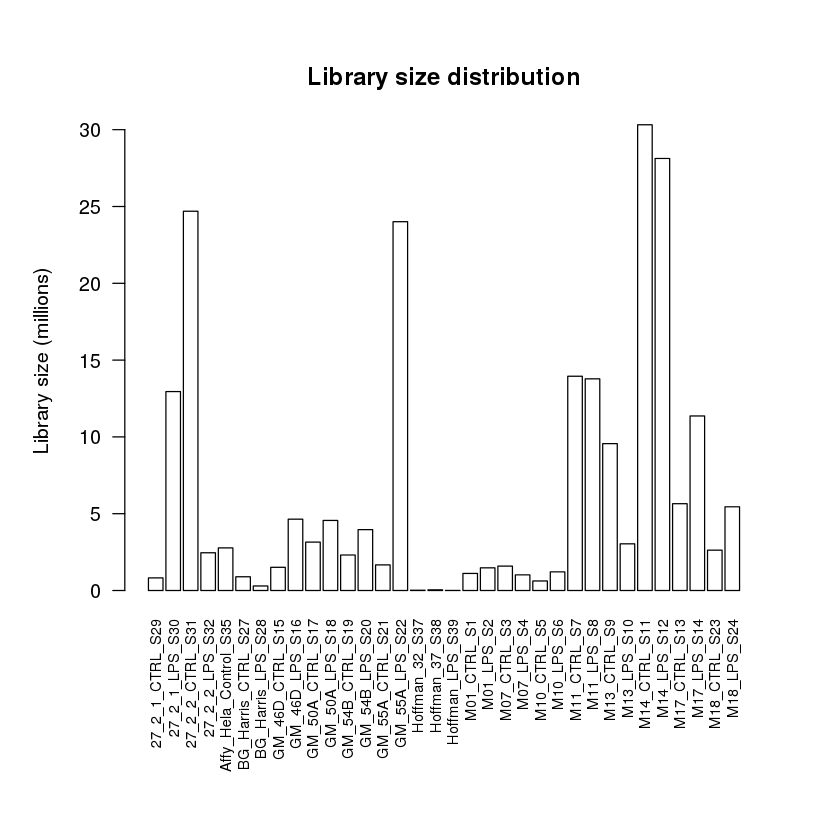

In [14]:
##Visualize library size distribution (# aligned reads)
par(oma=c(5,1,1,1) + 0.1) 
barplot(N*1e-6, 
        ylab="Library size (millions)", 
        main=c("Library size distribution"),
        names=names(N), 
        las=2,
        cex.names=0.75,
        col=colors
)

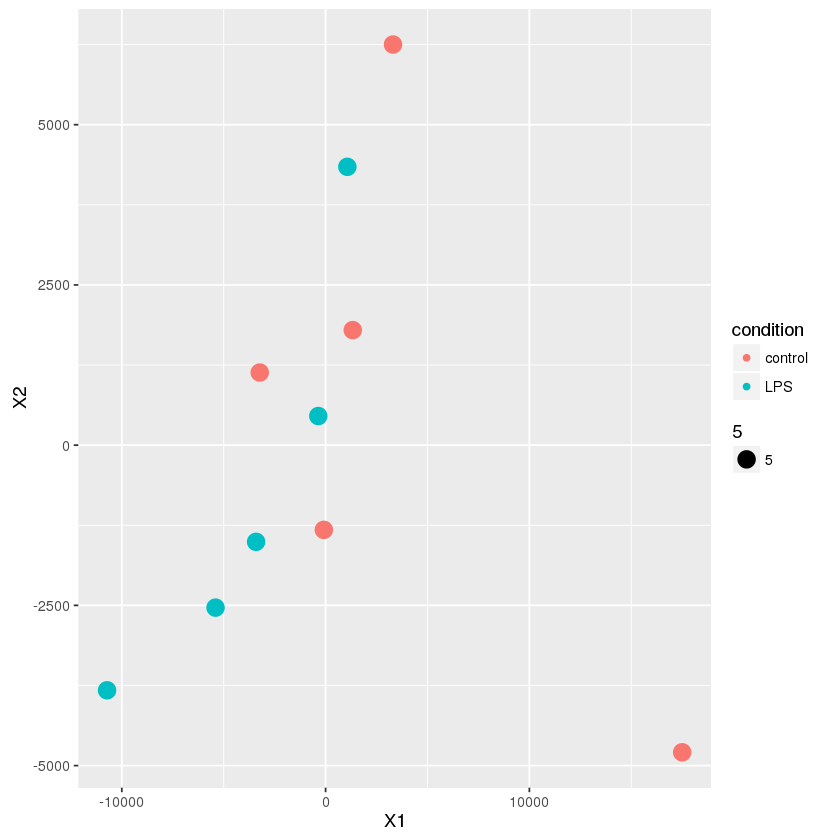

In [15]:
#Create MDS plot for all samples
poisd <- PoissonDistance(t(counts(dds)))
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( dds$dex, dds$cell, sep="-" )
mds <- data.frame(cmdscale(samplePoisDistMatrix))
mds <- cbind(mds, colData(rld))
mds <- as.data.frame(mds)
qplot(X1,X2,color=condition,data=mds,size=5)

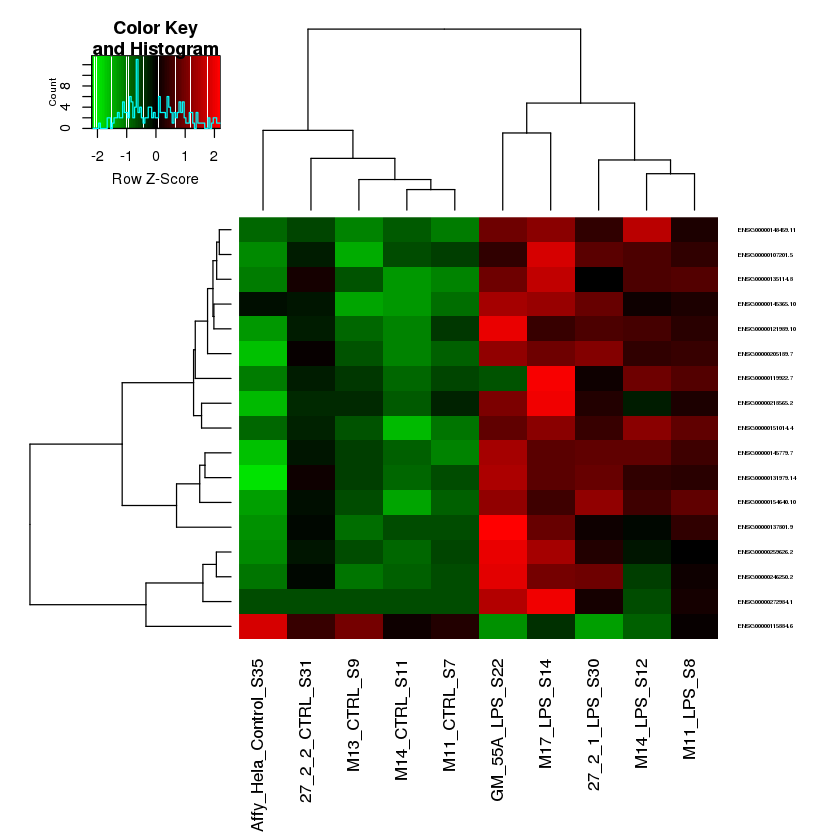

In [16]:
#Create Heatmap of differentially expressed transcripts
#DE <- subset(res, padj < 0.05) #specify level of DE
#DE <- subset(top$table, FDR < 0.05) #specify level of DE
DE <- subset(res, padj < 0.05) #specify level of DE
DE2 <- subset(DE,  abs(log2FoldChange) > 1) #specify level of DE

#DE <- subset(res, pvalue < 0.01)
useHeat <- row.names(DE2)
deseqHeat <- deseq[useHeat,] 
#deseqHeat <-deseqHeat[,]
par(oma=c(5,1,1,1) + 0.1) 
heatmap.2(deseqHeat, 
          Rowv=TRUE, 
          #Colv=hc, 
          col=rev(redgreen(75)), 
          scale="row", 
          #ColSideColors=unlist(sapply(group, mycol)), 
          trace="none", 
          key=TRUE,
          cexRow=0.35,
          cexCol=1,
          dendrogram="both"
          #labRow=TRUE
)

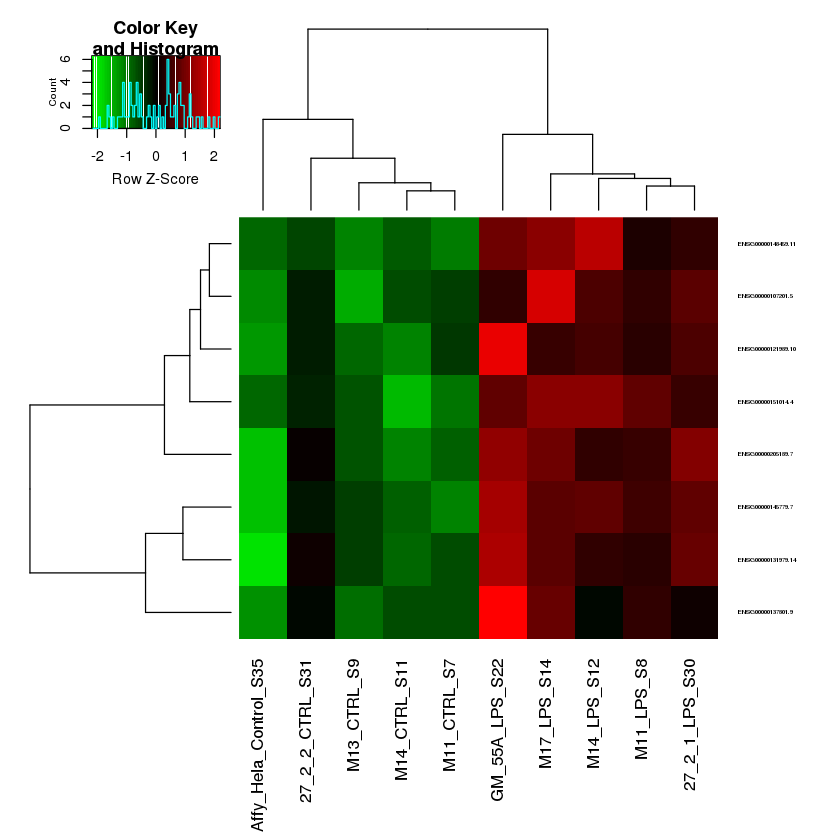

In [17]:
#Create Heatmap of differentially expressed coding genes

coding <- ANNOT_out_Coding$gene_id
DE <- subset(res, rownames(res) %in% coding) #specify level of DE
DE2 <- subset(DE,  padj < 0.05) #specify level of DE

useHeat <- row.names(DE2)
deseqHeat <- deseq[useHeat,] 
#deseqHeat <-deseqHeat[,]
par(oma=c(5,1,1,1) + 0.1) 
heatmap.2(deseqHeat, 
          Rowv=TRUE, 
          #Colv=hc, 
          col=rev(redgreen(75)), 
          scale="row", 
          #ColSideColors=unlist(sapply(group, mycol)), 
          trace="none", 
          key=TRUE,
          cexRow=0.35,
          cexCol=1,
          dendrogram="both"
          #labRow=TRUE
)

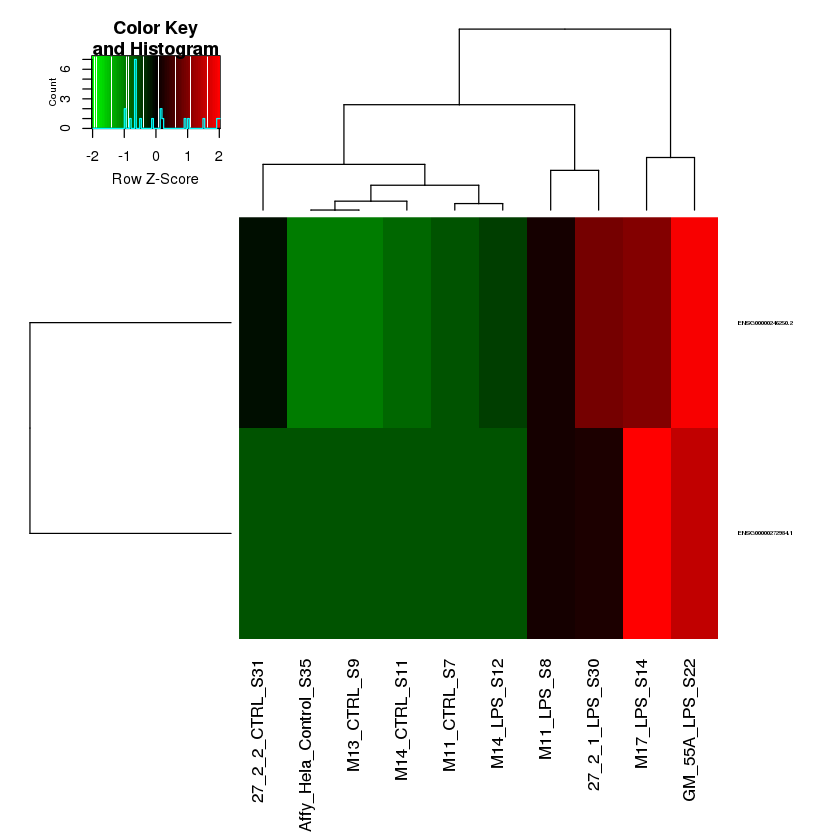

In [18]:
#Create heatmap of differentially expressed lncRNA

#png(sprintf("%s_%s_lncRNA_heatmap_%s.png", name, name2,date),res=1200, width=4,height=4, units='in')  #Uncomment this to save all plots to a pdf file

lnc <- ANNOT_out_lncRNA_unique$gene_id
DE <- subset(res, rownames(res) %in% lnc) #specify level of DE
DE2 <- subset(DE,  padj < 0.05) #specify level of DE
useHeat <- row.names(DE2)
deseqHeat <- deseq[useHeat,] 
#deseqHeat <-deseqHeat[,]
par(oma=c(5,1,1,1) + 0.1) 
heatmap.2(deseqHeat, 
          Rowv=TRUE, 
          #Colv=hc, 
          col=rev(redgreen(75)), 
          scale="row", 
          #ColSideColors=unlist(sapply(group, mycol)), 
          trace="none", 
          key=TRUE,
          cexRow=0.35,
          cexCol=1,
          dendrogram="both"
          #labRow=TRUE
)

## Switch back to Python2 Kernel
### Switch to R Kernel at top of screen: Kernel --> Change Kernel --> R

<a id = "enrichment"></a>
## Functional Enrichment Analysis -- ToppGene & WebGestalt 

Functional enrichment analyses were performed with ToppGene (https://toppgene.cchmc.org/enrichment.jsp) 
and WebGestalt (http://bioinfo.vanderbilt.edu/webgestalt). 
The websites for each of these tools are provided below. Cut and copy the DE gene list from the results above into these tools 
to interact with the results.

In [33]:
HTML('<iframe src="https://toppgene.cchmc.org/enrichment.jsp" width=95% height=600px></iframe>')

In [ ]:
#View Differentially Expressed Genes Interactively
all_DE_new = pandas.read_table("./results/DE_transcripts_Prince_RNAseq_20160405_LPSvsControl_QC_test_2016-04-05.csv")
DE_new = all_DE_new.loc[all_DE_new.pvalue < 0.01]
qgrid.show_grid(DE_new, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

In [34]:
#View ToppGene Results
toppgene = pandas.read_table("./report/figure/toppgene.txt")
qgrid.show_grid(toppgene.sample(1000), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

### Functional Enrichment Analysis -- Webgestalt

Type in email (you won't get spammed, don't worry)

Select organism of interest (hsapiens)

Select gene ID type (hsapiens_gene_symbol)

Go

Dropdown under Enrichment Analysis --> KEGG Analysis

Select Reference set for enrichment analysis --> hsapiens_entrezgene_protein-coding (ideally you upload a list of genes expressed in your tissue of interest, but protein-coding genes is ok for an example)

Significance Level -> 0.05

Leave others as default

Click "Run Enrichment Analysis"

New window will open

Click View Results

Click on Pathway Names to see diagram of pathway (red gene labels indicate those in your input list)

In [36]:
#View WebGestalt Results
IFrame("./report/figure/KEGG/final_KEGG_file_1439147189.html", width=1000, height=600)

In [35]:
HTML('<iframe src="http://bioinfo.vanderbilt.edu/webgestalt/option.php" width=95% height=600px></iframe>')

In [37]:
#View significant pathway
HTML('<iframe src="http://www.kegg.jp/pathway/hsa04621+6347+114548+257397+2920+6352+3553+329+4790+834+5970+7124+8767+7128+330+55914+3569+4792+3576+2919" width=95% height=1000px></iframe>')

<a id = "network"></a>
## Network Analysis

View "UVM_Top_20_Genes" project for an example network

Create new project

Insert gene list

Upload Node Data ("UVM_genes_for_network.txt")

Select options for network

Submit

View Network

Overlay node data --> Nodes --> Stylesheet

In [4]:
HTML('<iframe src="http://52.26.26.232/static/workflow/html/index.html" width=95% height=1000px></iframe>')

### Functional Enrichment Analysis -- ToppGene

Input list of gene symbols

Leave default settings --> Start

View results (signficance cutoff: FDR B&H <= E-5)